# Preparing data for Modelling

In [1]:
import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.style.use('ggplot')

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MaxAbsScaler, PowerTransformer
from sklearn.base import clone

import seaborn as sns

import quantstats as qs
import os 
# pd.set_option('display.max_rows', None)
import os 

# To automatically load changes in different files 
%load_ext autoreload
%autoreload 2


import seaborn as sns 
import matplotlib.pyplot as plt 
# Applying Settings to Viaualization Tools 
plt.rcParams['font.size'] = 13
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
# Set color palette to blue shades
sns.set_palette(["#003366", "#6699CC", "#99CCFF", "#99CCFF"])
sns.set_palette(["#002855", "#3E7EAA", "#82B5D8", "#B3D9F2"])
plt.rcParams['font.family'] = 'Times New Roman'
sns.set_style("darkgrid")

In [2]:
from utils import search_folder
current_dir = os.getcwd()
thesis_folder_path = current_dir.replace("master_thesis_coding", "")
twitter_data_path = search_folder(thesis_folder_path,"twitter_data")
eikon_data_path = search_folder(thesis_folder_path,"eikon_news")
stock_data_path = search_folder(thesis_folder_path,"stock_prices")
modelling_data_path = search_folder(thesis_folder_path,"modelling_data")
google_trending_path = search_folder(thesis_folder_path,"google_search")

In [3]:
def read_modelling(path, name):
    df = pd.read_csv(path+name)
    df["datetime"] = pd.to_datetime(df["datetime"])
    df = df.sort_values(by = "datetime", ascending = True)
    df = df.reset_index(drop = True)
    return df

---
## Stock Data 

In [4]:
stock_data_df = read_modelling(modelling_data_path, "/all_stocks_returns_df.csv")
stock_data_df

,datetime,close,net,ret,open,low,high,volume,turnover_usd,flow,company
0,2017-01-03,14.465986,NaN,NaN,14.323986,14.063986,14.688652,8.884890e+07,1.283684e+09,0.000000e+00,tesla
1,2017-01-03,29.037500,NaN,NaN,28.950000,28.690000,29.082500,1.151275e+08,3.327549e+09,0.000000e+00,apple
2,2017-01-04,29.005000,-0.032500,-0.001119,28.962500,28.937500,29.127500,8.447246e+07,2.452484e+09,-2.452484e+09,apple
3,2017-01-04,15.132652,0.666666,0.046085,14.316652,14.287319,15.199985,1.682022e+08,2.511866e+09,2.511866e+09,tesla
4,2017-01-05,29.152500,0.147500,0.005085,28.980000,28.952500,29.216050,8.877435e+07,2.584690e+09,1.322059e+08,apple
...,...,...,...,...,...,...,...,...,...,...,...
4156,2023-02-27,207.630000,10.750000,0.054602,202.030000,201.260000,209.420000,1.610283e+08,3.322295e+10,2.072545e+12,tesla
4157,2023-02-27,138.270000,-0.990000,-0.007109,139.520000,136.720000,140.910000,4.965970e+06,6.894097e+08,5.894183e+10,moderna
4158,2023-02-28,147.410000,-0.510000,-0.003448,147.050000,146.830000,149.080000,5.054700e+07,7.470828e+09,3.945905e+11,apple
4159,2023-02-28,205.710000,-1.920000,-0.009247,210.590000,203.750000,211.230000,1.531449e+08,3.171329e+10,2.040832e+12,tesla


---
## Fama French Model Features 

In [5]:
fama_french_feat_df = read_modelling(modelling_data_path, "/fama_variables_companies.csv")
fama_french_feat_df

,datetime,beta_mktrf,beta_smb,beta_hml,beta_rmw,beta_cma,idvar_ff5,company
0,2017-01-03,NaN,NaN,NaN,NaN,NaN,NaN,moderna
1,2017-01-03,NaN,NaN,NaN,NaN,NaN,NaN,tesla
2,2017-01-03,NaN,NaN,NaN,NaN,NaN,NaN,apple
3,2017-01-03,NaN,NaN,NaN,NaN,NaN,NaN,apple
4,2017-01-03,NaN,NaN,NaN,NaN,NaN,NaN,moderna
...,...,...,...,...,...,...,...,...
6445384,2023-02-28,1.214102,0.045854,-0.494590,0.742419,-0.116845,0.023102,apple
6445385,2023-02-28,-0.046194,-1.017071,1.677783,-1.032327,-6.698418,0.337214,tesla
6445386,2023-02-28,1.214102,0.045854,-0.494590,0.742419,-0.116845,0.023102,apple
6445387,2023-02-28,-0.046194,-1.017071,1.677783,-1.032327,-6.698418,0.337214,tesla


In [6]:
# joining stock data with fama french factors
master_test = pd.merge(stock_data_df, fama_french_feat_df, how = "left", left_on=["datetime", "company"], right_on = ["datetime", "company"])
master_test = master_test.drop_duplicates()

---
## Twitter Sentiment Model Features 

In [7]:
sentiment_df = read_modelling(twitter_data_path, "/twitter_senti_df.csv")
sentiment_df = sentiment_df[sentiment_df["company"] == "moderna"]
sentiment_df = sentiment_df.set_index(pd.to_datetime(sentiment_df.datetime))
sentiment_df = sentiment_df[["Textblob_senti", "Vader_sentim", "Finbert_sentim"]].resample("D").sum()

---
## Eikon Sentiment  Features 

---
## Topic Modelling Features

---
## Google Trending News for Companies

In [8]:
def fix_google_data(df): 
    for idx in range(len(df)):
        
        current_date = pd.to_datetime(df['datetime'].iloc[idx])
        
        if current_date.weekday() == 6:
            df.at[idx, 'datetime'] = current_date + pd.Timedelta(days=2)
        
        elif current_date.weekday() == 7: 
            
            df.at[idx, 'datetime'] = current_date + pd.Timedelta(days=1) 
        else:
            continue
    
    return df

In [9]:
comp_google_search_df = read_modelling(modelling_data_path, "/google_searches_companies.csv")
comp_google_search_df.head()

,datetime,interest,company
0,2018-04-08,31,apple
1,2018-04-15,1,moderna
2,2018-04-15,33,apple
3,2018-04-15,18,tesla
4,2018-04-22,31,apple


In [10]:
comp_google_search_df = fix_google_data(comp_google_search_df)

In [11]:
comp_google_search_df

,datetime,interest,company
0,2018-04-10,31,apple
1,2018-04-17,1,moderna
2,2018-04-17,33,apple
3,2018-04-17,18,tesla
4,2018-04-24,31,apple
...,...,...,...
776,2023-03-28,37,apple
777,2023-03-28,3,moderna
778,2023-04-04,40,tesla
779,2023-04-04,3,moderna


---
## Google Trending News for Macro-News

In [12]:
makro_google_search_df = read_modelling(modelling_data_path, "/google_macro_searches.csv")
makro_google_search_df

,datetime,pandemic_mentions,inflation_mentions
0,2018-04-08,1,17
1,2018-04-15,1,16
2,2018-04-22,1,17
3,2018-04-29,1,17
4,2018-05-06,1,16
...,...,...,...
256,2023-03-05,4,33
257,2023-03-12,4,37
258,2023-03-19,4,36
259,2023-03-26,3,34


In [13]:
makro_google_search_df = fix_google_data(makro_google_search_df)
makro_google_search_df

,datetime,pandemic_mentions,inflation_mentions
0,2018-04-10,1,17
1,2018-04-17,1,16
2,2018-04-24,1,17
3,2018-05-01,1,17
4,2018-05-08,1,16
...,...,...,...
256,2023-03-07,4,33
257,2023-03-14,4,37
258,2023-03-21,4,36
259,2023-03-28,3,34


---
## Macro-Economic Data

In [14]:
macro_data_df = read_modelling(modelling_data_path, "/macro_data.csv")
macro_data_df

,datetime,euro_doll_bid,euro_doll_ask,eur_doll_high,eur_doll_low,eur_doll_open,refresh_rate,euro_doll_bidnet,nasdaq_close,nasdaqd_net,nasdaqd_ret,nasdaq_open,nasdaq_low,nasdaq_high,nasdaq_volume
0,2017-01-03,1.0404,1.0408,1.0490,1.0339,1.0453,74707.0,-0.0053,4911.334,NaN,NaN,4900.854,4884.522,4928.490,152438794
1,2017-01-04,1.0486,1.0490,1.0499,1.0387,1.0403,91660.0,0.0082,4937.205,25.871,0.005268,4920.792,4919.803,4944.745,141126335
2,2017-01-05,1.0603,1.0611,1.0615,1.0478,1.0489,103626.0,0.0117,4964.953,27.748,0.005620,4936.355,4935.343,4967.901,140485654
3,2017-01-06,1.0530,1.0536,1.0621,1.0520,1.0603,92864.0,-0.0073,5007.077,42.124,0.008484,4973.868,4957.821,5020.699,131384869
4,2017-01-09,1.0572,1.0576,1.0582,1.0508,1.0537,108645.0,0.0042,5024.899,17.822,0.003559,5013.820,5009.451,5033.321,140374244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1544,2023-02-22,1.0601,1.0605,1.0663,1.0597,1.0646,74530.0,-0.0045,12066.272,5.974,0.000495,12085.674,12006.038,12156.214,265179372
1545,2023-02-23,1.0595,1.0598,1.0627,1.0575,1.0603,67058.0,-0.0006,12180.140,113.868,0.009437,12224.444,12003.306,12227.403,284877502
1546,2023-02-24,1.0546,1.0550,1.0614,1.0534,1.0595,65876.0,-0.0049,11969.652,-210.488,-0.017281,11979.799,11900.839,12018.321,263448425
1547,2023-02-27,1.0607,1.0611,1.0619,1.0531,1.0540,84549.0,0.0061,12057.788,88.136,0.007363,12106.792,12034.613,12159.638,225910837


---
## Features Table

In [15]:
# joining stock data with fama french factors
master_test = pd.merge(stock_data_df, fama_french_feat_df, how = "left", left_on=["datetime", "company"], right_on = ["datetime", "company"])
master_test = master_test.drop_duplicates()

In [16]:
#  joining master table with macro data from Eikon 
master_test = pd.merge(master_test, macro_data_df, how = "left", left_on=["datetime"], right_on = ["datetime"])
master_test = master_test.drop_duplicates()

In [17]:
# Joining master table with makro data from google search 
master_test = pd.merge(master_test, makro_google_search_df, how = "left", left_on=["datetime"], right_on = ["datetime"])
master_test = master_test.drop_duplicates()

In [18]:
# Joining master table with makro data from google search 
master_test = pd.merge(master_test, comp_google_search_df, how = "left", left_on=["datetime", "company"], right_on = ["datetime", "company"])
master_test = master_test.drop_duplicates()

--- 
### 7 - Additional Features: (Technical Analysis, Sentiment, Price patterns, etc.)

In [19]:
def compute_techincal_labels(df, col_to_pred):
    
    # Computing 1 day forward target prediction  
    target_var = "future_target"
    df[target_var] = df[col_to_pred].shift(-1)
    
    for lag in range(0,11): 
        df["lag_"+ str(lag)] = df[col_to_pred].shift(lag)
         
    df['mean2w'] = df["lag_0"].rolling(window=10).mean()
    df['std2w'] = df["lag_0"].rolling(window=10).std()
    df['std1w'] = df["lag_0"].rolling(window=5).std()
    
    # for senti_var in ["Textblob_senti", "Vader_sentim",	"Finbert_sentim"]: 
    #     for lag in range(1, 600, 2): 
    #         df["rolled_"+ senti_var+"_" +str(lag)] = df[senti_var].rolling(window = lag, min_periods=1).mean()
            
    # global all_stm
    # all_stm = list(df.columns[28:])
    
    # for senti_var in all_stm:        
    #     for lag in range(1,10): 
    #         df["lag_"+ str(lag)+ senti_var] = df[senti_var].shift(lag)

    df = df.drop(columns = [col_to_pred])
    
    df.fillna(0.0)

    return df

---
### Selecting Company and Adding Sentiment Variables

In [33]:
company = "moderna"
company_pred_df = master_test[master_test["company"] == company]
company_pred_df["interest"] = company_pred_df["interest"].ffill()
company_pred_df["rolling_interest"] = company_pred_df["interest"].rolling(3).mean().ffill()
company_pred_df["pandemic_mentions"] = company_pred_df["pandemic_mentions"].ffill()
company_pred_df["inflation_mentions"] = company_pred_df["inflation_mentions"].ffill()

In [48]:
sentiment_df = read_modelling(twitter_data_path, "/quick_test.csv")
sentiment_df

,datetime,Textblob_senti,Vader_sentim
0,2019-01-01 00:00:00+00:00,0.000000,0.0000
1,2019-01-02 00:00:00+00:00,2.054444,-0.2439
2,2019-01-03 00:00:00+00:00,0.308586,0.2960
3,2019-01-04 00:00:00+00:00,0.553776,1.7364
4,2019-01-05 00:00:00+00:00,0.131944,0.4904
...,...,...,...
1560,2023-04-10 00:00:00+00:00,2.951515,-0.3894
1561,2023-04-11 00:00:00+00:00,11.965581,3.4529
1562,2023-04-12 00:00:00+00:00,0.443750,-1.1859
1563,2023-04-13 00:00:00+00:00,1.848333,1.0518


In [49]:
# sentiment_df = read_modelling(twitter_data_path, "/twitter_senti_df.csv")
# sentiment_df = sentiment_df[sentiment_df["company"] == company]
sentiment_df = sentiment_df.set_index(pd.to_datetime(sentiment_df.datetime))
sentiment_df = sentiment_df[["Textblob_senti", "Vader_sentim"]].resample("D").sum()
sentiment_df = sentiment_df.reset_index()

In [50]:
company_pred_df["datetime"] = pd.to_datetime(company_pred_df["datetime"], utc = True)
company_pred_df_senti = pd.merge(company_pred_df, sentiment_df, how = "left", on = ["datetime"])
company_pred_df_senti = compute_techincal_labels(company_pred_df_senti, "close")
company_pred_df_senti = company_pred_df_senti.fillna(0.0)

In [51]:
macro_vars = ['open', 'low', 'high', 'volume', 'euro_doll_bid',
            'euro_doll_ask','eur_doll_high','eur_doll_low', 'eur_doll_open',
            'refresh_rate', 'euro_doll_bidnet', 'nasdaq_close', 'nasdaqd_net',
            'nasdaqd_ret','nasdaq_open', 'nasdaq_low','nasdaq_high','nasdaq_volume']

google_vars = ["pandemic_mentions",	"inflation_mentions",'interest','rolling_interest']

lagged_vars = ['lag_0','lag_1', 'lag_2','lag_3','lag_4','lag_5','lag_6','lag_7','lag_8','lag_9', "lag_10"]

techni_vars = ['mean2w','std2w','std1w']

fama_vars = ['beta_mktrf','beta_smb','beta_hml','beta_rmw','beta_cma']

Ssenti_vars = ['Textblob_senti','Vader_sentim']

for senti_var in Ssenti_vars: 
    for lag in range(1, 20, 1): 
        company_pred_df_senti["rolled_"+ senti_var + "_" +str(lag)] = company_pred_df_senti[senti_var].rolling(window = lag, min_periods=0).mean()

Csenti_vars = list(company_pred_df_senti.columns[52:])
date = ["datetime"]

future_target = ["future_target"]

In [52]:
all_feat = date + macro_vars + google_vars + lagged_vars + techni_vars + fama_vars + future_target
modelling_ft = macro_vars + google_vars + lagged_vars + techni_vars + fama_vars #+ Ssenti_vars + Csenti_vars

In [53]:
company_pred_df_senti[Csenti_vars]

,rolled_Textblob_senti_2,rolled_Textblob_senti_3,rolled_Textblob_senti_4,rolled_Textblob_senti_5,rolled_Textblob_senti_6,rolled_Textblob_senti_7,rolled_Textblob_senti_8,rolled_Textblob_senti_9,rolled_Textblob_senti_10,rolled_Textblob_senti_11,rolled_Textblob_senti_12,rolled_Textblob_senti_13,rolled_Textblob_senti_14,rolled_Textblob_senti_15,rolled_Textblob_senti_16,rolled_Textblob_senti_17,rolled_Textblob_senti_18,rolled_Textblob_senti_19,rolled_Vader_sentim_1,rolled_Vader_sentim_2,rolled_Vader_sentim_3,rolled_Vader_sentim_4,rolled_Vader_sentim_5,rolled_Vader_sentim_6,rolled_Vader_sentim_7,rolled_Vader_sentim_8,rolled_Vader_sentim_9,rolled_Vader_sentim_10,rolled_Vader_sentim_11,rolled_Vader_sentim_12,rolled_Vader_sentim_13,rolled_Vader_sentim_14,rolled_Vader_sentim_15,rolled_Vader_sentim_16,rolled_Vader_sentim_17,rolled_Vader_sentim_18,rolled_Vader_sentim_19
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1058,3.015704,3.342155,4.062772,3.917648,3.638780,3.473847,3.192220,3.013010,2.792126,2.626023,2.415521,2.491348,2.267346,2.172765,2.176191,2.295997,2.275240,2.211861,-1.1191,0.46655,-1.671667,0.223950,0.25916,0.651833,0.934671,0.929875,1.149644,1.22443,1.114227,1.010567,1.032131,0.902286,0.954853,0.841088,1.135629,1.184072,1.227658
1059,6.811771,5.535453,5.150354,5.365207,5.027198,4.629662,4.361485,4.012523,3.769204,3.499655,3.288434,3.043170,3.068748,2.821186,2.697902,2.670236,2.755939,2.712067,3.5566,1.21875,1.496567,-0.364600,0.89048,0.808733,1.066800,1.262413,1.221733,1.39034,1.436445,1.317758,1.206415,1.212450,1.079240,1.117463,1.000824,1.270128,1.308942
1060,7.868842,6.262092,5.442273,5.152830,5.331462,5.046560,4.696296,4.450512,4.127544,3.895889,3.638245,3.432611,3.194567,3.208347,2.967533,2.842892,2.808708,2.882613,8.2092,5.88290,3.548900,3.174725,1.35016,2.110267,1.865943,1.959600,2.034278,1.92048,2.010236,2.000842,1.847869,1.706614,1.678900,1.524863,1.534624,1.401289,1.635342
1061,3.775656,6.042087,5.293714,4.831534,4.692121,4.911050,4.714312,4.439883,4.244319,3.969457,3.770279,3.542117,3.358037,3.140835,3.157111,2.933477,2.817652,2.786596,5.1102,6.65970,5.625333,3.939225,3.56182,1.976833,2.538829,2.271475,2.309667,2.34187,2.210455,2.268567,2.240023,2.080893,1.933520,1.893356,1.735765,1.733267,1

In [54]:
simple_vars = ["datetime",'open','low','high','volume', "future_target", "rolled_Textblob_senti_3","rolled_Textblob_senti_9", "rolled_Textblob_senti_18"]
simple_model = ['open','low','high','volume', "rolled_Textblob_senti_3","rolled_Textblob_senti_9", "rolled_Textblob_senti_18"] + lagged_vars + techni_vars
company_pred_df_senti = company_pred_df_senti[simple_vars+lagged_vars + techni_vars]

In [55]:
company_pred_df_senti.head(10)

,datetime,open,low,high,volume,future_target,rolled_Textblob_senti_3,rolled_Textblob_senti_9,rolled_Textblob_senti_18,lag_0,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,mean2w,std2w,std1w
0,2018-12-07 00:00:00+00:00,22.00,18.51,22.7500,12995569.0,18.80,0.0,0.0,0.0,18.60,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.000,0.000000,0.000000
1,2018-12-10 00:00:00+00:00,18.90,18.00,19.4388,4233345.0,18.01,0.0,0.0,0.0,18.80,18.60,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.000,0.000000,0.000000
2,2018-12-11 00:00:00+00:00,20.55,17.99,20.6600,3435271.0,18.68,0.0,0.0,0.0,18.01,18.80,18.60,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.000,0.000000,0.000000
3,2018-12-12 00:00:00+00:00,18.55,18.02,19.4800,2590873.0,18.76,0.0,0.0,0.0,18.68,18.01,18.80,18.60,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.000,0.000000,0.000000
4,2018-12-13 00:00:00+00:00,19.25,18.68,19.2900,1608629.0,18.32,0.0,0.0,0.0,18.76,18.68,18.01,18.80,18.60,0.00,0.00,0.00,0.0,0.0,0.0,0.000,0.000000,0.322335
5,2018-12-14 00:00:00+00:00,18.75,18.25,18.8806,746412.0,17.00,0.0,0.0,0.0,18.32,18.76,18.68,18.01,18.80,18.60,0.00,0.00,0.0,0.0,0.0,0.000,0.000000,0.339676
6,2018-12-17 00:00:00+00:00,18.33,16.90,18.4700,1581242.0,17.00,0.0,0.0,0.0,17.00,18.32,18.76,18.68,18.01,18.80,18.60,0.00,0.0,0.0,0.0,0.000,0.000000,0.711323
7,2018-12-18 00:00:00+00:00,17.10,16.25,17.2500,1621904.0,16.18,0.0,0.0,0.0,17.00,17.00,18.32,18.76,18.68,18.01,18.80,18.60,0.0,0.0,0.0,0.000,0.000000,0.884715
8,2018-12-19 00:00:00+00:00,16.86,16.00,17.3700,941528.0,15.50,0.0,0.0,0.0,16.18,17.00,17.00,18.32,18.76,18.68,18.01,18.80,18.6,0.0,0.0,0.000,0.000000,1.059585
9,2018-12-20 00:00:00+00:00,16.00,14.75,16.1400,2365203.0,14.47,0.0,0.0,0.0,15.50,16.18,17.00,17.00,18.32,18.76,18.68,18.01,18.8,18.6,0.0,17.685,1.188493,1.056504


<Axes: >

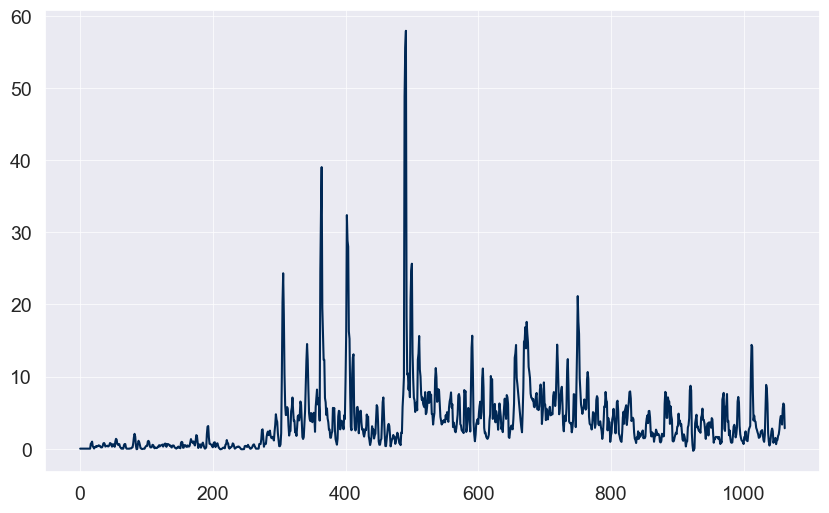

In [63]:
company_pred_df_senti.rolled_Textblob_senti_3.plot(
)

In [56]:
xgboost_test = {'xgboost': {'alpha_estimation_method':'Lasso', "alpha": 0.0}}
#xgboost_test = {'xgboost': {'alpha_estimation_method':'xgboost'}}

In [57]:
from class_backtester import Backtester as bk 
backtester = bk(df = company_pred_df_senti, 
                params = None,
                modeling_features = simple_model,
                rolling_frw = '1D',
                look_back_prm = 252, 
                configurations= xgboost_test, 
                col_to_pred = 'future_target',
                days_avoid_bias = 0)

backtester.run_backtest()

100%|██████████| 1291/1291 [07:25<00:00,  2.90it/s]


In [58]:
resutls_df = backtester.dict_all_predictions["xgboost"][["datetime", "future_target","future_target_pred"]]

In [59]:
resutls_df['y_test'] = (resutls_df['future_target'] > resutls_df['future_target'].shift()).astype(int)
resutls_df['y_test'] = resutls_df['y_test'].fillna(0)
resutls_df['y_pred'] = (resutls_df['future_target_pred'] > resutls_df['future_target_pred'].shift()).astype(int)
resutls_df['y_pred'] = resutls_df['y_pred'].fillna(0)
resutls_df = resutls_df.set_index("datetime")

In [60]:
from utils import model_evaluate

              precision    recall  f1-score   support

           0       0.48      0.48      0.48       445
           1       0.48      0.48      0.48       443

    accuracy                           0.48       888
   macro avg       0.48      0.48      0.48       888
weighted avg       0.48      0.48      0.48       888



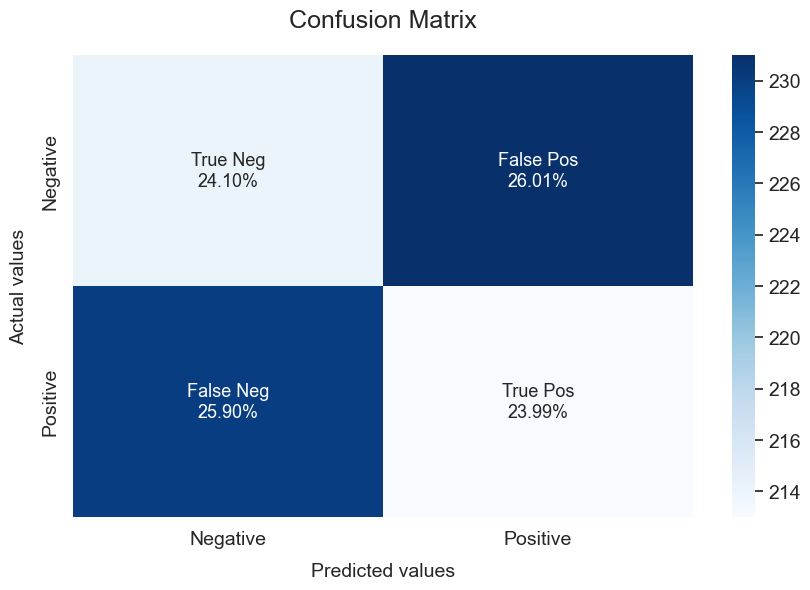

In [61]:
model_evaluate(resutls_df["y_test"], resutls_df["y_pred"]) # 49 or 48 

<Axes: xlabel='datetime'>

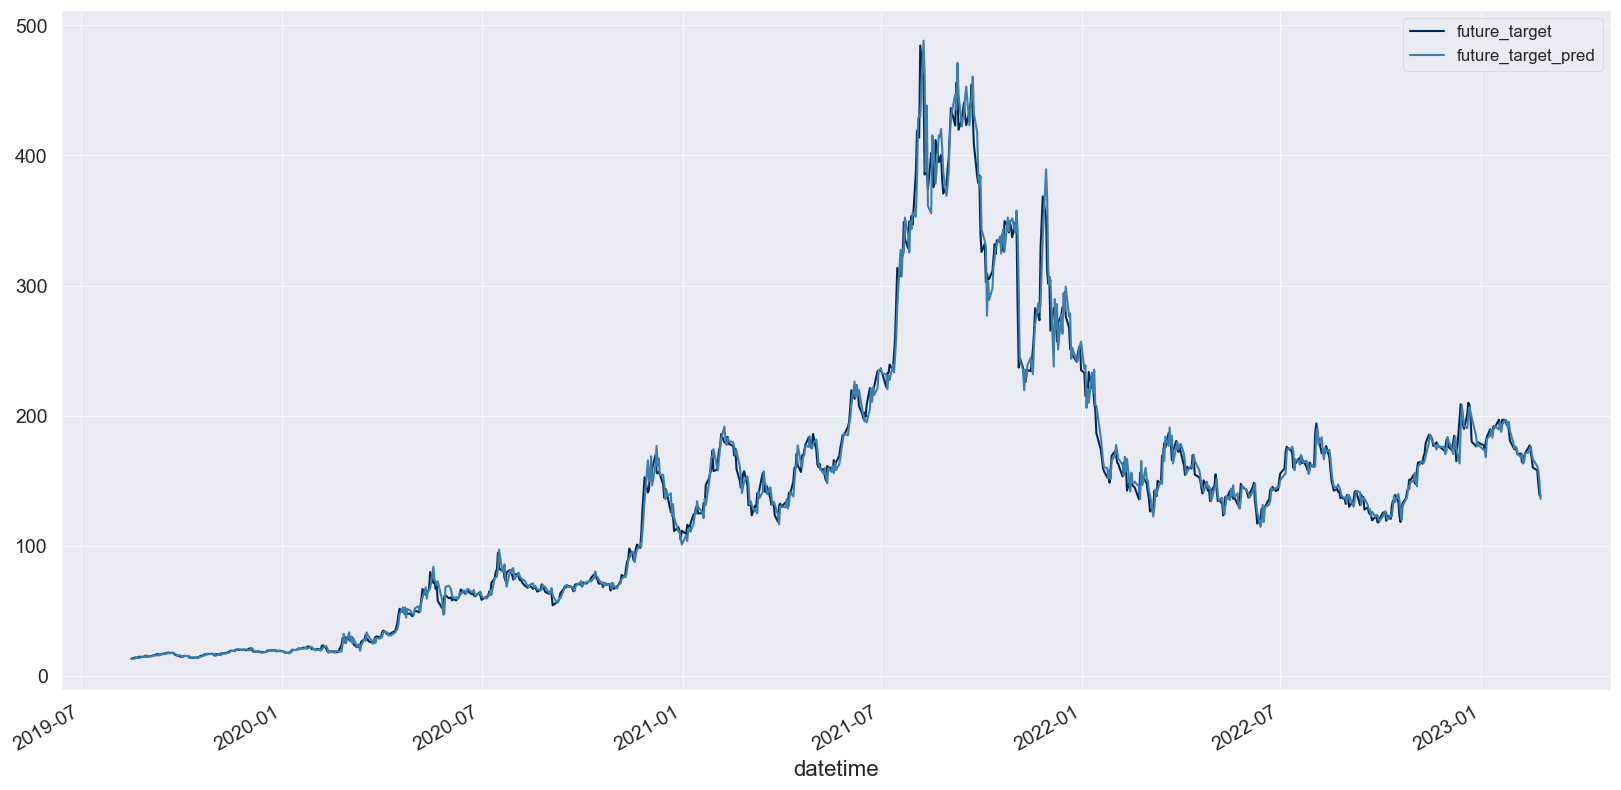

In [1414]:
resutls_df.iloc[:,:2].plot(figsize = (20,10))